<a href="https://colab.research.google.com/github/allenphos/ML-course/blob/main/Copy_of_HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/edce80b5bb02479085855b2334b17fc1). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [29]:
!pip install opendatasets --upgrade --quiet

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)
Area under ROC score on Training dataset: 0.8839%
[[0.95843214 0.04156786]
 [0.46149645 0.53850355]]


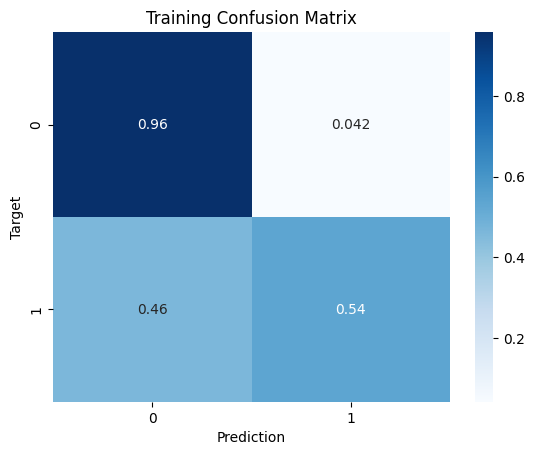

Area under ROC score on Validation dataset: 0.8752%
[[0.95604856 0.04395144]
 [0.4599018  0.5400982 ]]


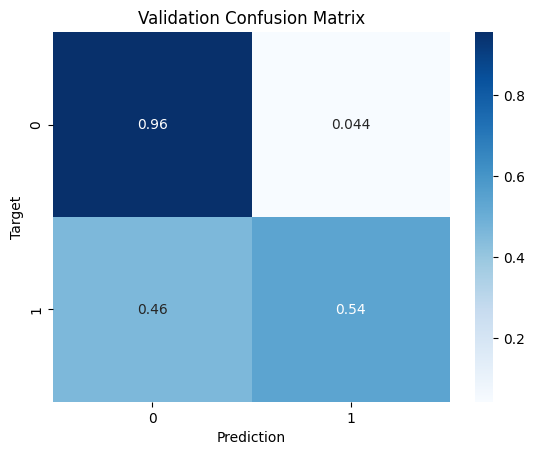

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import GridSearchCV
import opendatasets as od


# Download the dataset
od.download("https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2")
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv', index_col=0)

# Create training, validation and test sets
train_val_df, test_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['Exited'], random_state=42)

# Create inputs and targets
input_cols = list(train_df.columns)[3:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that includes preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
#model_pipeline.fit(train_inputs, train_targets)


# Виконуємо GridSearchCV тільки один раз
param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model_pipeline, param_grid, scoring='roc_auc', cv=5)

# Навчаємо модель (виконується один раз)
grid_search.fit(train_inputs, train_targets)

# Отримуємо найкращу модель
best_model = grid_search.best_estimator_


# Helper function to predict, compute accuracy & plot confusion matrix
def predict_and_plot(model, inputs, targets=None, name=''):
    preds_proba = model.predict_proba(inputs)[:, 1]
    preds = model.predict(inputs)

    # Візуалізація (якщо є справжні значення)
    if targets is not None:
        fpr, tpr, thresholds = roc_curve(targets, preds_proba, pos_label=1)
        roc_auc = auc(fpr, tpr)
        print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}%")

        confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
        print(confusion_matrix_)
        plt.figure()
        sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
        plt.xlabel('Prediction')
        plt.ylabel('Target')
        plt.title(f'{name} Confusion Matrix')
        plt.show()

    return preds

# Evaluate on validation and test set
train_preds = predict_and_plot(best_model, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(best_model, val_inputs, val_targets, 'Validation')

# Save the trained model
joblib.dump(best_model, 'log_reg_pipeline.joblib')

# Load the trained model
best_model_pipeline_loaded = joblib.load('log_reg_pipeline.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Training dataset: 0.9306%
[[0.96205886 0.03794114]
 [0.33096668 0.66903332]]


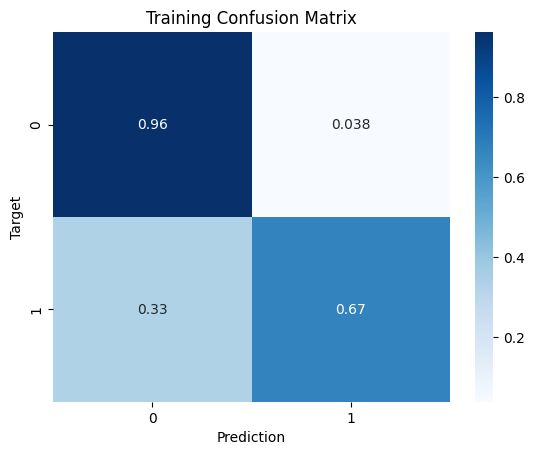

Area under ROC score on Validation dataset: 0.9237%
[[0.95646714 0.04353286]
 [0.34697218 0.65302782]]


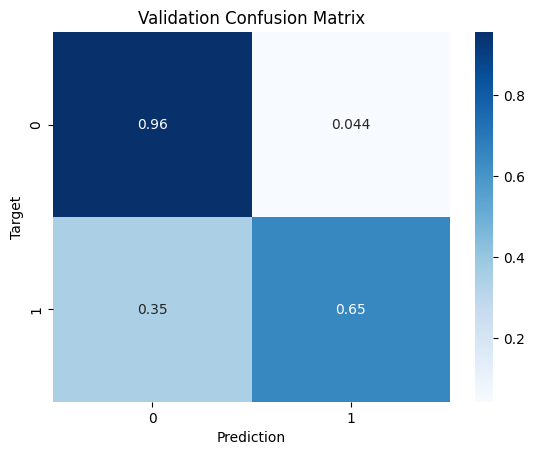

In [3]:
from sklearn.preprocessing import PolynomialFeatures

# Новий трансформер для числових колонок з поліноміальними ознаками
numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())  # Нормалізація після генерації ознак
])

# Оновлений препроцесор
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Новий пайплайн
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренування моделі
model_pipeline_poly.fit(train_inputs, train_targets)

# Evaluate on validation and test set
train_preds = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Validation')



Виглядає так, що модель добре генералізує. Точність моделі покращилась.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Training dataset: 0.9393%
[[0.96122193 0.03877807]
 [0.30966685 0.69033315]]


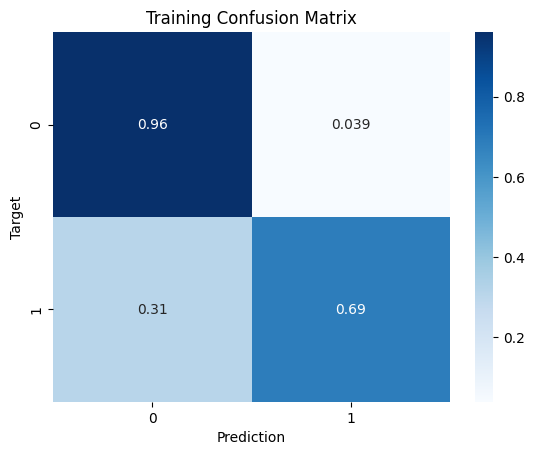

Area under ROC score on Validation dataset: 0.9268%
[[0.95939724 0.04060276]
 [0.31587561 0.68412439]]


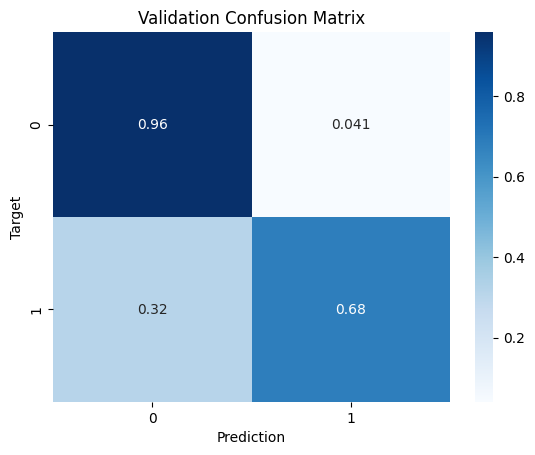

In [4]:
# Новий трансформер для числових колонок з поліноміальними ознаками
numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler())  # Нормалізація після генерації ознак
])

# Оновлений препроцесор
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Новий пайплайн
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренування моделі
model_pipeline_poly.fit(train_inputs, train_targets)

# Evaluate on validation and test set
train_preds = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Validation')


Точність моделі трохи покращилась.

Area under ROC score on Training dataset: 0.9426%
[[0.96136142 0.03863858]
 [0.30857455 0.69142545]]


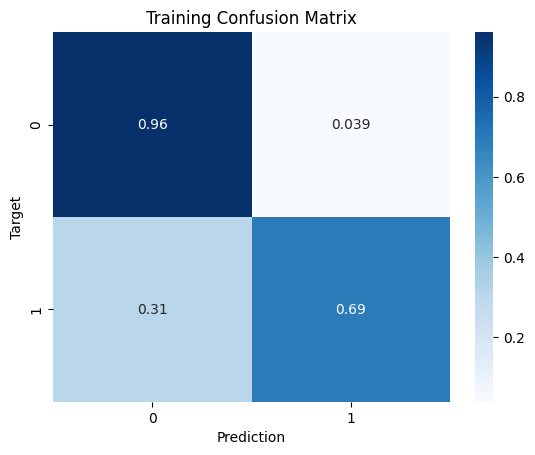

Area under ROC score on Validation dataset: 0.9268%
[[0.95814148 0.04185852]
 [0.30932897 0.69067103]]


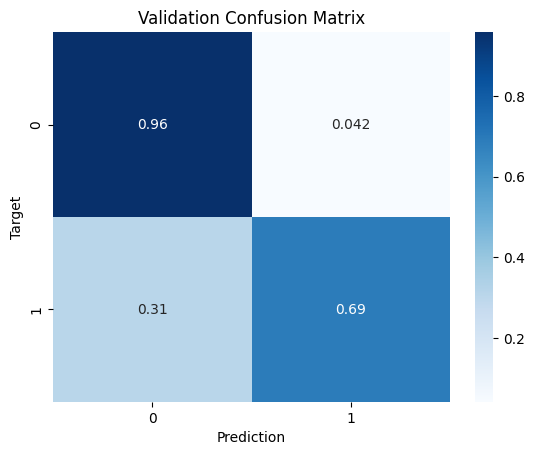

In [5]:
# Новий трансформер для числових колонок з поліноміальними ознаками
numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', StandardScaler())  # Нормалізація після генерації ознак
])

# Оновлений препроцесор
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Новий пайплайн
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренування моделі
model_pipeline_poly.fit(train_inputs, train_targets)

# Evaluate on validation and test set
train_preds = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Validation')

In [44]:
# Helper function to predict, compute accuracy & plot confusion matrix
def predict_(model_pipeline, inputs):
    preds = model_pipeline.predict_proba(inputs)[:,1]
    return preds

# Evaluate on validation and test set
#train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')

In [45]:
test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/test.csv')
# Assuming you have the test data loaded in `test_df`
test_inputs = test_raw_df[input_cols]
test_raw_df['Exited'] = predict_(model_pipeline_poly, test_inputs)

sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv')
sample_submission = sample_submission.reset_index(drop=True)
test_raw_df = test_raw_df.reset_index(drop=True)
sample_submission['Exited'] = test_raw_df['Exited']

sample_submission.to_csv('submission_log_reg.csv', index=False)

sample_submission['Exited']

,Exited
0,0.058256
1,0.010234
2,0.062032
3,0.410827
4,0.016492
...,...
9995,0.001796
9996,0.005281
9997,0.011755
9998,0.093582


## **Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import root_mean_squared_error


# Download the dataset
raw_df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/regression_data.csv')

# Розбиття на features (X) та target (y)
X = raw_df.drop(columns=['target'])
y = raw_df['target']

# Поділ на train і test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def train_lin_vs_poly_reg(X_train, X_val, y_train, y_val, degree=5):
    # Лінійна регресія без поліноміальних ознак
    lin_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    lin_pipeline.fit(X_train, y_train)
    y_pred_train_lin = lin_pipeline.predict(X_train)
    y_pred_val_lin = lin_pipeline.predict(X_val)

    # Поліноміальна регресія
    poly_pipeline = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    poly_pipeline.fit(X_train, y_train)
    y_pred_train_poly = poly_pipeline.predict(X_train)
    y_pred_val_poly = poly_pipeline.predict(X_val)

    # Оцінка моделей
    rmse_lin_train = root_mean_squared_error(y_train, y_pred_train_lin)
    rmse_poly_train = root_mean_squared_error(y_train, y_pred_train_poly)

    rmse_lin_val = root_mean_squared_error(y_val, y_pred_val_lin)
    rmse_poly_val = root_mean_squared_error(y_val, y_pred_val_poly)

    print(f"Train RMSE for Linear Regression: {rmse_lin_train:.3f}")
    print(f"Test RMSE for Linear Regression: {rmse_lin_val:.3f}\n")

    print(f"Train RMSE for Polynomial Regression (degree {degree}): {rmse_poly_train:.3f}")
    print(f"Test RMSE for Polynomial Regression (degree {degree}): {rmse_poly_val:.3f}")



In [2]:
degree = 2
train_lin_vs_poly_reg(X_train, X_val, y_train, y_val, degree)

Train RMSE for Linear Regression: 1.066
Test RMSE for Linear Regression: 0.883

Train RMSE for Polynomial Regression (degree 2): 1.017
Test RMSE for Polynomial Regression (degree 2): 1.015


In [3]:
degree = 3
train_lin_vs_poly_reg(X_train, X_val, y_train, y_val, degree)

Train RMSE for Linear Regression: 1.066
Test RMSE for Linear Regression: 0.883

Train RMSE for Polynomial Regression (degree 3): 0.799
Test RMSE for Polynomial Regression (degree 3): 1.916


In [4]:
degree = 5
train_lin_vs_poly_reg(X_train, X_val, y_train, y_val, degree)

Train RMSE for Linear Regression: 1.066
Test RMSE for Linear Regression: 0.883

Train RMSE for Polynomial Regression (degree 5): 0.000
Test RMSE for Polynomial Regression (degree 5): 12.677


В лінійной регресії на тестових даних помилка зменшилась. Що говорить про хорошу генералізацію моделі. Помилка зростає якщо використовувати PolynomialFeatures.

В поліномінальний регресії при високих значеннях degree, в даних можна побачити overfit. Модель занадто складна для даних.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [26]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

def poly_lin_vs_rle_(X_train, X_val, y_train, y_val, degree=5):

    # Список моделей
  models = {
    "Linear Regression with PolynomialFeatures": LinearRegression(),
    "Ridge (alpha=1)                          ": Ridge(alpha=1),
    "Ridge (alpha=2)                          ": Ridge(alpha=2),
    "Lasso (alpha=0.1)                        ": Lasso(alpha=0.1, max_iter=10000),
    "ElasticNet (alpha=0.5)                   ": ElasticNet(alpha=0.5, max_iter=10000)
  }

  # Створення поліноміальних ознак
  poly = PolynomialFeatures(degree=degree, include_bias=False)
  X_train_poly = poly.fit_transform(X_train)
  X_val_poly = poly.transform(X_val)

  # Масштабування
  scaler = StandardScaler()
  X_train_poly_scaled = scaler.fit_transform(X_train_poly)
  X_val_poly_scaled = scaler.transform(X_val_poly)

  results = {}

  for name, model in models.items():
      model.fit(X_train_poly_scaled, y_train)
      y_train_pred = model.predict(X_train_poly_scaled)
      y_val_pred = model.predict(X_val_poly_scaled)

      train_rmse = root_mean_squared_error(y_train, y_train_pred)
      val_rmse = root_mean_squared_error(y_val, y_val_pred)

      results[name] = {"Train RMSE": train_rmse, "Validation RMSE": val_rmse}

  # Виводимо результати
  print("\n Оцінка регуляризованих моделей:")
  for model_name, metrics in results.items():
      print(f"{model_name}: Train RMSE = {metrics['Train RMSE']:.3f}, Validation RMSE = {metrics['Validation RMSE']:.3f}")

train_lin_vs_poly_reg(X_train, X_val, y_train, y_val, 1)
poly_lin_vs_rle_(X_train, X_val, y_train, y_val, degree=1)

Train RMSE for Linear Regression: 1.066
Test RMSE for Linear Regression: 0.883

Train RMSE for Polynomial Regression (degree 1): 1.066
Test RMSE for Polynomial Regression (degree 1): 0.883

 Оцінка регуляризованих моделей:
Linear Regression with PolynomialFeatures: Train RMSE = 1.066, Validation RMSE = 0.883
Ridge (alpha=1)                          : Train RMSE = 1.149, Validation RMSE = 0.937
Ridge (alpha=2)                          : Train RMSE = 1.361, Validation RMSE = 1.191
Lasso (alpha=0.1)                        : Train RMSE = 1.083, Validation RMSE = 0.849
ElasticNet (alpha=0.5)                   : Train RMSE = 9.088, Validation RMSE = 10.087


In [13]:
poly_lin_vs_rle_(X_train, X_val, y_train, y_val, degree=2)


 Оцінка регуляризованих моделей:
Linear Regression with PolynomialFeatures: Train RMSE = 1.017, Validation RMSE = 1.015
Ridge (alpha=1)                          : Train RMSE = 1.114, Validation RMSE = 1.152
Ridge (alpha=2)                          : Train RMSE = 1.356, Validation RMSE = 1.490
Lasso (alpha=0.1)                        : Train RMSE = 1.075, Validation RMSE = 0.858
ElasticNet (alpha=0.5)                   : Train RMSE = 9.119, Validation RMSE = 10.877


In [7]:
poly_lin_vs_rle_(X_train, X_val, y_train, y_val, degree=6)


 Оцінка регуляризованих моделей:
Linear Regression with PolynomialFeatures: Train RMSE = 0.000, Validation RMSE = 16.411
Ridge (alpha=1)                          : Train RMSE = 1.071, Validation RMSE = 23.228
Ridge (alpha=2)                          : Train RMSE = 1.719, Validation RMSE = 23.605
Lasso (alpha=0.1)                        : Train RMSE = 0.971, Validation RMSE = 0.868
ElasticNet (alpha=0.5)                   : Train RMSE = 8.643, Validation RMSE = 17.641


In [8]:
poly_lin_vs_rle_(X_train, X_val, y_train, y_val, degree=12)


 Оцінка регуляризованих моделей:
Linear Regression with PolynomialFeatures: Train RMSE = 0.000, Validation RMSE = 22.154
Ridge (alpha=1)                          : Train RMSE = 1.051, Validation RMSE = 36.525
Ridge (alpha=2)                          : Train RMSE = 1.665, Validation RMSE = 46.529
Lasso (alpha=0.1)                        : Train RMSE = 0.962, Validation RMSE = 0.878
ElasticNet (alpha=0.5)                   : Train RMSE = 8.609, Validation RMSE = 17.284


In [9]:
poly_lin_vs_rle_(X_train, X_val, y_train, y_val, degree=20)


 Оцінка регуляризованих моделей:
Linear Regression with PolynomialFeatures: Train RMSE = 0.000, Validation RMSE = 65.391
Ridge (alpha=1)                          : Train RMSE = 1.054, Validation RMSE = 27.798
Ridge (alpha=2)                          : Train RMSE = 1.665, Validation RMSE = 20.615
Lasso (alpha=0.1)                        : Train RMSE = 0.965, Validation RMSE = 1.277
ElasticNet (alpha=0.5)                   : Train RMSE = 8.603, Validation RMSE = 17.330


Краще всього генералізує Лассо на тестувальних даних із найменшою кількістю поліномінльних ознак. Інші моделі перенавчились і показують високу помилку на тестових даних.

In [24]:
# Створює поліноміальні ознаки
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)

# Навчає Lasso-регресію на цих ознаках
model = Lasso(alpha=0.1, max_iter=10000)
model.fit(X_train_poly, y_train) # Lasso-регресія використовує L1-регуляризацію (Lasso може зануляти ваги менш важливих ознак)

# Створює таблицю з назвами ознак та їхніми коефіцієнтами
coefs_df = pd.DataFrame(poly_features.get_feature_names_out(X_train.columns), columns=['feature_name'])
coefs_df['value'] = model.coef_.round(5).flatten()

# Сортує ознаки за значенням коефіцієнтів та візуалізує
coefs_df.set_index('feature_name').sort_values(by='value', ascending=False).style.background_gradient()

,value
feature_name,
feature_4,49.776590
feature_5^2,0.035790
feature_2^2,0.016600
feature_1,0.012500
feature_2 feature_3,0.012290
feature_4 feature_5,-0.000000
feature_3 feature_5,0.000000
feature_3 feature_4,0.000000
feature_3^2,0.000000


Після Lasso більшість ознак мають вагу 0, це означає, що модель знайшла найважливіші змінні.

У таблиці можна подивитися, які ознаки Lasso залишив, а які обнулив. Та зрозуміти , які змінні найбільше впливають на цільову (y_train). Перевірити, чи є зайві ознаки (наприклад, якщо занулено більшість поліноміальних ознак, то degree=2 може бути занадто високим)

Модель занадто "агресивно" відкидає ознаки. Це може означати, що alpha (регуляризація) занадто висока. Чи можлива проблема мультиколінеарності (Якщо поліноміальні ознаки сильно корелюють, Lasso може вибрати одну і занулити інші.)


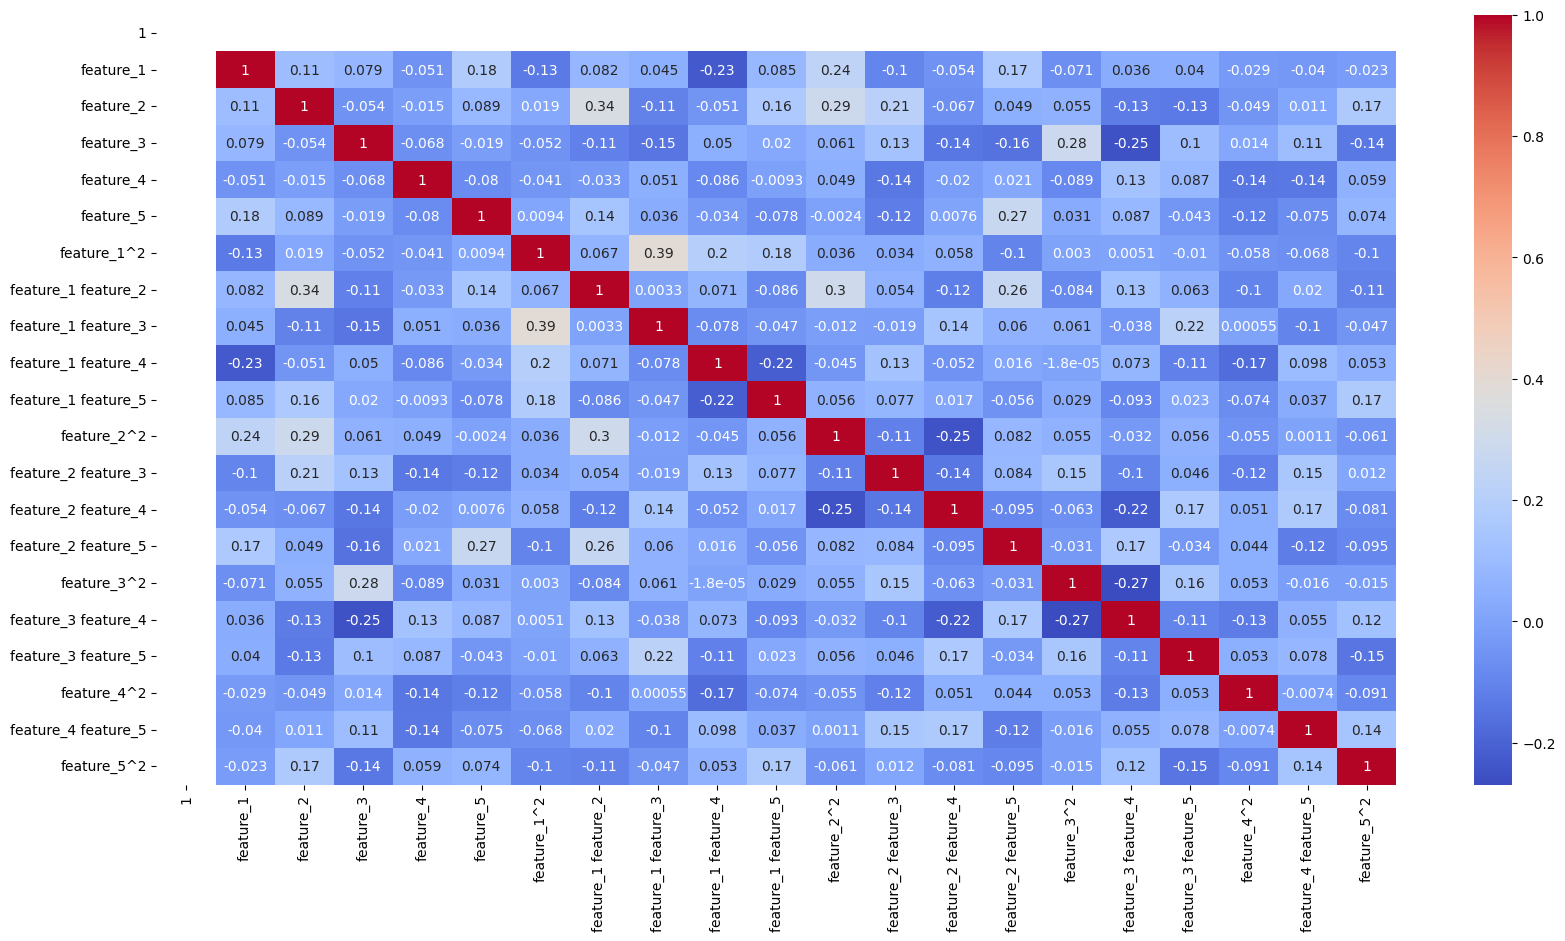

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(pd.DataFrame(X_train_poly, columns=poly_features.get_feature_names_out()).corr(), annot=True, cmap="coolwarm")
plt.show()


Якщо багато червоних або синіх комірок, модель може страждати від мультиколінеарності.

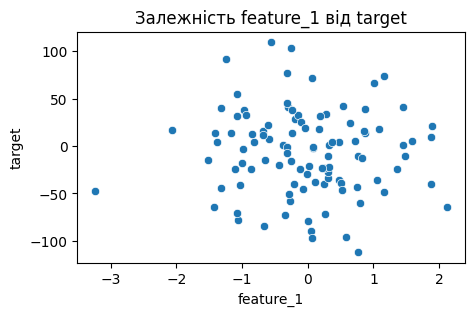

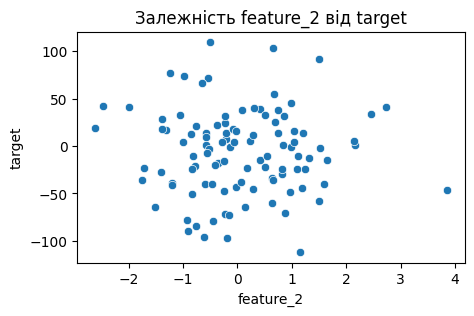

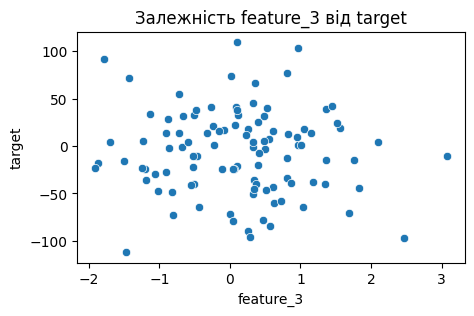

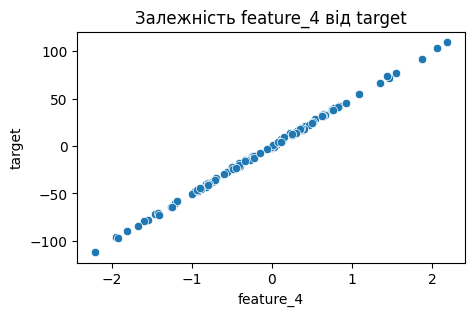

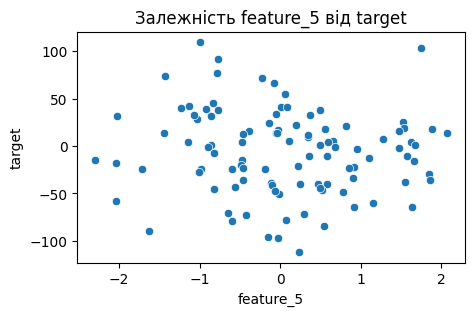

In [28]:
# Аналіз впливу ознак на цільову змінну
df = pd.concat([X_train, y_train], axis=1)

for col in X_train.columns:
    plt.figure(figsize=(5, 3))
    sns.scatterplot(x=df[col], y=df['target'])
    plt.title(f"Залежність {col} від target")
    plt.show()

У задачах регресії ми часто хочемо, щоб модель не просто будувала лінійну залежність між ознаками та цільовою змінною, а могла виявити нелінійні патерни.
Замість того, щоб використовувати тільки початкові змінні (x1, x2), ми додаємо їхні степені та комбінації (x1², x2², x1*x2 тощо). Це дозволяє моделі виявляти складніші взаємозв’язки між ознаками. Після додавання нових ознак модель може краще навчитися знаходити складні взаємозв’язки!

Регуляризація (Lasso, Ridge, ElasticNet)
Якщо додати занадто багато поліноміальних ознак, модель може занадто добре запам’ятати навчальні дані та перестати добре працювати на нових.

🔹 Регуляризація допомагає запобігти перенавчанню, зменшуючи "важливість" певних ознак.
Вона додає штраф за занадто великі коефіцієнти (w).

Ridge (L2-регуляризація) Використовується, коли всі ознаки важливі, і потрібно просто зменшити їхній вплив.

ElasticNet (L1 + L2)  Гарний вибір, коли є багато ознак, але частину з них треба відкинути.


✅ Поліноміальні ознаки допомагають моделі виявити нелінійні залежності.
✅ Lasso допомагає відкинути неважливі ознаки.
✅ Ridge допомагає зменшити ваги ознак, не зануляючи їх.
✅ ElasticNet поєднує переваги обох методів.

🔹 Що краще використовувати?

Якщо є дуже багато зайвих ознак → Lasso
Якщо всі ознаки важливі, але є мультиколінеарність → Ridge
Якщо є і те, і те → ElasticNet